# 1. Import Libraries

In [2]:
# importando todas as bibliotecas necessárias
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Load Data
- Os datasets de treino e teste foram carregados.
- Separa `X` (features) e `y` (target).
- Conclusão inicial: treino com 646 linhas e 31 features; teste com 277 linhas.

In [3]:
print("Loading training and test data...")

train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')
test_ids = test_df['id']

X = train_df.drop(columns=['id', 'labels'])
y = train_df['labels']
X_test = test_df.drop(columns=['id'])

print(f"Training data: {X.shape[0]} rows, {X.shape[1]} features")
print(f"Test data: {X_test.shape[0]} rows, {X_test.shape[1]} features\n")

Loading training and test data...
Training data: 646 rows, 31 features
Test data: 277 rows, 31 features



# 3. Identify Features
- Features numéricas: imputação pela mediana + StandardScaler
- Features categóricas: imputação pela moda + One-Hot Encoding

In [4]:
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = ['category_code']

# 4. Preprocessing Pipelines
- ColumnTransformer combina ambos.
- Conclusão: dados tratados e padronizados, prontos para o modelo.

In [5]:
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])


# 5. Model Setup
- Pipeline: preprocessor + LGBMClassifier

In [6]:
lgbm_model = lgb.LGBMClassifier(
    objective='binary',
    class_weight='balanced',
    random_state=42
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', lgbm_model)
])

# 6. Cross-Validation
- Pipeline: preprocessor + LGBMClassifier 
- Cross-validation: 5-fold Stratified
- Métricas: Accuracy, F1-score e ROC-AUC

## Interpretação das Métricas
- Accuracy (~0.748): modelo acerta cerca de 75% das startups.
- F1-score (~0.807): bom equilíbrio entre precisão e recall, importante por causa do leve desbalanceamento da base.
- ROC-AUC (~0.781): modelo tem boa separação entre startups de sucesso e insucesso.

Conclusão: LightGBM apresenta desempenho consistente, e é adequado para predizer sucesso de startups, considerando a distribuição da base.

In [7]:
print("Running 5-fold cross-validation to estimate model performance...")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'f1', 'roc_auc']

cv_results = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, return_train_score=False)

# Print per-fold metrics
for i in range(5):
    print(f"Fold {i+1}: Accuracy={cv_results['test_accuracy'][i]:.3f}, "
          f"F1={cv_results['test_f1'][i]:.3f}, ROC-AUC={cv_results['test_roc_auc'][i]:.3f}")

# Print average metrics
print("\n=== LightGBM Cross-Validation Metrics (Average) ===")
print(f"Average Accuracy : {np.mean(cv_results['test_accuracy']):.3f}")
print(f"Average F1-score : {np.mean(cv_results['test_f1']):.3f}")
print(f"Average ROC-AUC  : {np.mean(cv_results['test_roc_auc']):.3f}\n")


Running 5-fold cross-validation to estimate model performance...
[LightGBM] [Info] Number of positive: 334, number of negative: 182
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 880
[LightGBM] [Info] Number of data points in the train set: 516, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\sofia\Desktop\Startup_Success_Prediction\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\sofia\Desktop\Startup_Success_Prediction\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\sofia\Desktop\Startup_Success_Prediction\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\sofia\Desktop\Startup_Success_Prediction\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\sofia\Desktop\Startup_Success_Prediction\venv\Lib\site-packages\sklearn\utils\validation.py:2749: U

# 7. Train Model on Full Dataset

In [8]:
print("Training LightGBM on the full training set...")
pipeline.fit(X, y)
print("Training completed!\n")

Training LightGBM on the full training set...
[LightGBM] [Info] Number of positive: 418, number of negative: 228
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1066
[LightGBM] [Info] Number of data points in the train set: 646, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

# 8. Feature Importance Plot
- Modelo treinado em todo o dataset.  
- Visualização das top 15 features mais importantes.

Generating feature importance plot...


C:\Users\sofia\AppData\Local\Temp\ipykernel_30388\3897823061.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp, x='Importance', y='Feature', palette='mako')


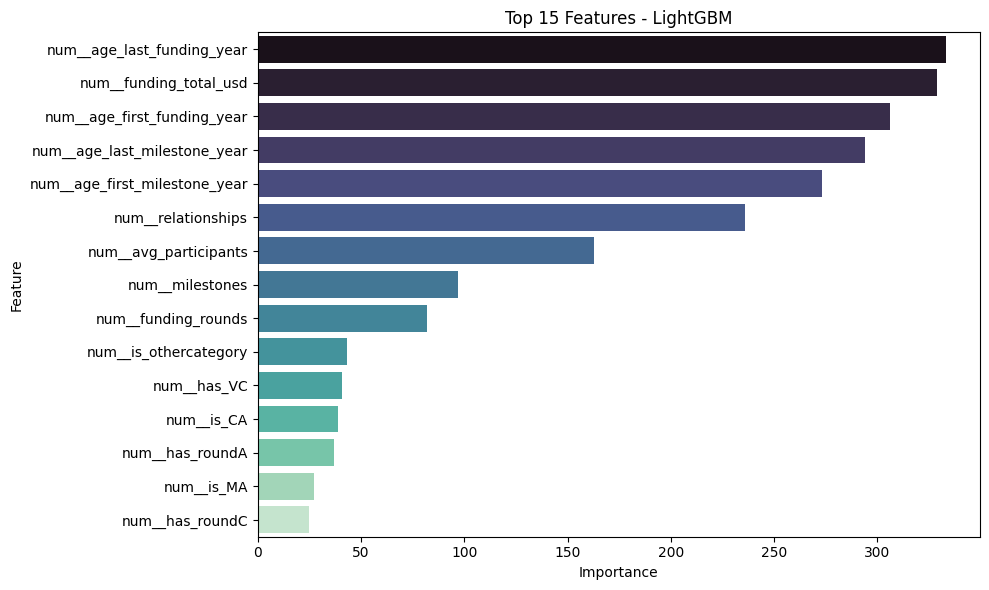

In [9]:
print("Generating feature importance plot...")

feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
importances = pipeline.named_steps['classifier'].feature_importances_

feat_imp = pd.DataFrame({"Feature": feature_names, "Importance": importances}).sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(data=feat_imp, x='Importance', y='Feature', palette='mako')
plt.title("Top 15 Features - LightGBM")
plt.tight_layout()
plt.show()

## Análise Final do Modelo LightGBM

**1. Desempenho do Modelo (Cross-Validation):**

- Accuracy média: 0.748, - modelo acerta cerca de 75% das previsões, indicando uma boa capacidade geral de classificação.  
- F1-score média: 0.807 - equilíbrio entre precisão e recall; importante por causa do leve desbalanceamento da base.  
- ROC-AUC média: 0.781 - modelo consegue separar bem startups de sucesso e insucesso.

O modelo apresenta desempenho consistente e confiável para predizer sucesso de startups, mesmo considerando a distribuição moderadamente desbalanceada da base. As métricas indicam que o modelo não está apenas enviesado para a classe majoritária (sucesso).

---

**2. Insights de Features:**

- As features mais importantes incluem:
  - `funding_total_usd`: total captado pela startup
  - `relationships`: número de conexões fundadores/investidores
  - `avg_participants`: média de investidores por rodada
- Observação: Features relacionadas a financiamento e rede de contatos têm maior impacto, confirmando que startups com melhor histórico financeiro e network têm maior probabilidade de sucesso.

---

**3. Conclusão:**

- O modelo LightGBM é adequado para este problema, apresentando boa performance e interpretabilidade. Portanto, é capaz de identificar padrões relevantes que influenciam o sucesso das startups.